In [62]:
import json
import numpy as np
import torch
import matplotlib.pyplot as plt
import pickle as pkl
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score
from sklearn.base import TransformerMixin
from torch import nn
from sklearn.model_selection import StratifiedKFold, learning_curve, LearningCurveDisplay

def load_dataset(filepath):
    with open(filepath, "r") as f:
        dataset = [ json.loads(line, parse_int = str) for line in f ]
    return dataset

def get_vectorizer( texts: list[str], *, method="countvectorize", **kwargs ) -> CountVectorizer:
    """From a list of texts, output an appropriate vectorizer either using CountVectorizer or TF-IDF depending on method argument. 

     Args:
         texts (list[str]): list of strings, each item corresponding to a text.
         method (str, optional): Method to select features. Defaults to "count-vectorizer".
         **kwargs: kwarg arguments to pass to Vectorizer classes of sklearn.
    Raises:
        ValueError: If passing an non-specified method of text feature extraction

     Returns:
         pd.DataFrame: dataframe of shape (n_samples, n_features)
    """
    #We want single digits to be tokenized. This regex considers everything as a token except whitespace.
    kwargs['token_pattern'] = r'\S+' 
    if method == "countvectorize":
        vectorizer = CountVectorizer(**kwargs)
    elif method == "tfidf":
        vectorizer = TfidfVectorizer(**kwargs)
    else:
        raise ValueError(f"{method} is not a supported method.")
    #Use texts to initialize vocabulary of vectorizer
    vectorizer.fit(texts)
    return vectorizer

def sentencify(text: list) -> str:
    sentence = " ".join(text) 
    return sentence

def balanced_acc(clf, X, y):
    y_pred = clf.predict(X)
    return balanced_accuracy_score(y, y_pred, adjusted=False)

In [2]:
dataset_1 = load_dataset("domain1_train_data.json")
datatexts_1 = [ sentencify(instance['text']) for instance in dataset_1 ]

dataset_2 = load_dataset("domain2_train_data.json")
datatexts_2 = [ sentencify(instance['text']) for instance in dataset_2 ]

In [3]:
with open("domain_classifier/domain_classifier_mnb.mdl", "rb") as f:
    DC_vectorizer_mnb, DC_mnb = pkl.load(f)

In [6]:
with open("domain1_models/domain1_LR.mdl", "rb") as f:
    D1_vectorizer_lr, D1_lr = pkl.load(f)

In [7]:
with open("domain2_models/domain2_lr.mdl", "rb") as f:
    D2_vectorizer_lr, D2_lr = pkl.load(f)

In [9]:
domain_features = DC_vectorizer_mnb.transform( datatexts_1 + datatexts_2 ).toarray()
domain_probs = DC_mnb.predict_proba( domain_features )[:,1]
del domain_features

In [11]:
domain1_features_1 = D1_vectorizer_lr.transform( datatexts_1 ).toarray()

lengths = np.zeros( (5000, 2) )
for i in range(5000):
    for k in range(2):
        lengths[i,k] = len(dataset_1[i]['text'])**(k+1)
        
domain1_features_1 = np.hstack( (domain1_features_1, lengths) )
domain1_probs_1 = D1_lr.predict_proba( domain1_features_1 )[:,1]

del domain1_features_1

In [12]:
domain1_features_2 = D1_vectorizer_lr.transform( datatexts_2 ).toarray()

lengths = np.zeros( (13000, 2) )
for i in range(13000):
    for k in range(2):
        lengths[i,k] = len(dataset_2[i]['text'])**(k+1)
        
domain1_features_2 = np.hstack( (domain1_features_2, lengths) )
domain1_probs_2 = D1_lr.predict_proba( domain1_features_2 )[:,1]
del domain1_features_2

domain1_probs = np.concatenate( [domain1_probs_1, domain1_probs_2] )
del domain1_probs_1, domain1_probs_2

In [14]:
domain2_features_1 = D2_vectorizer_lr.transform( datatexts_1 ).toarray()

lengths = np.zeros( (5000, 2) )
for i in range(5000):
    for k in range(2):
        lengths[i,k] = len(dataset_1[i]['text'])**(k+1)
        
domain2_features_1 = np.hstack( (domain2_features_1, lengths) )
domain2_probs_1 = D2_lr.predict_proba( domain2_features_1 )[:,1]

del domain2_features_1

In [15]:
domain2_features_2 = D2_vectorizer_lr.transform( datatexts_2 ).toarray()

lengths = np.zeros( (13000, 2) )
for i in range(13000):
    for k in range(2):
        lengths[i,k] = len(dataset_2[i]['text'])**(k+1)
        
domain2_features_2 = np.hstack( (domain2_features_2, lengths) )
domain2_probs_2 = D2_lr.predict_proba( domain2_features_2 )[:,1]
del domain2_features_2

domain2_probs = np.concatenate( [domain2_probs_1, domain2_probs_2] )
del domain2_probs_1, domain2_probs_2

In [29]:
class NeuralNetworkDropOut(nn.Module):
    def __init__(self, n_inputs, n_outputs = 1, n_layers = 1, n_neurons_per_layer = None, leaky_slope = 0.01, dropout_prob=0.1):
        if n_layers > 0:
            try:
                assert n_neurons_per_layer is not None
                assert len(n_neurons_per_layer) == n_layers
            except Exception as e:
                raise ValueError("provide numbers of neurons per layer defined by n_layers")
        
        super().__init__()
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(dropout_prob)
        if n_layers >= 1:
            stack = [ nn.Linear( n_inputs, n_neurons_per_layer[0] ), self.dropout ]
            for k in range(n_layers-1):
                stack += [ nn.LeakyReLU(leaky_slope), nn.Linear(n_neurons_per_layer[k], n_neurons_per_layer[k+1]), self.dropout ]
            stack += [ nn.LeakyReLU(leaky_slope), nn.Linear(n_neurons_per_layer[n_layers-1], n_outputs) ]
        else:
            stack = [ nn.Linear( n_inputs, n_outputs ) ]
        
        self.linear_relu_stack = nn.Sequential( *stack )
        self.prob_predictor = nn.Sigmoid()
        self.loss = nn.BCEWithLogitsLoss()
        for name, param in self.named_parameters():
            param.data.uniform_(-0.5,0.5)
            
    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits
    
    def predict(self, x):
        logits = self.forward(x)
        return self.prob_predictor(logits)
    
    def loss_fn(self, x, y):
        logits = self.forward(x)
        return self.loss(logits, y)

In [32]:
tfidf_vectorizer = get_vectorizer( texts = datatexts_1 + datatexts_2,
                                    method='tfidf',
                                    use_idf=True,
                                    ngram_range=(1,3),
                                    max_df=0.995, #Ignore vocabulary appearing too frequently, probably words like "is", "are", "and", "this" etc.
                                    min_df=10, #Ignore vocabulary that is too infrequent, as this may lead to low prediction accuracy.
                                    )
print(f"no features: {tfidf_vectorizer.get_feature_names_out().size}")

no features: 110827


In [79]:
lengths = np.zeros( (18000, 2) )
for i in range(5000):
    for k in range(2):
        lengths[i,k] = len(dataset_1[i]['text'])**(k+1)
for i in range(13000):
    for k in range(2):
        lengths[5000+i,k] = len(dataset_2[i]['text'])**(k+1)
lengths[:,0] /= lengths.max(axis=0)[0]
lengths[:,1] /= lengths.max(axis=0)[1]

In [34]:
with open("temp_selector.pkl", "rb") as f:
    selector = pkl.load(f)
X = tfidf_vectorizer.transform( datatexts_1 + datatexts_2 ).toarray()
X = np.hstack( (X, lengths) )
X = selector.transform(X)

In [38]:
mps_device = torch.device("mps")
model = NeuralNetworkDropOut( X.shape[1], 4, 3, [1000, 500, 100], dropout_prob=0.5, leaky_slope=0.001 )
model.prob_predictor = nn.Softmax(dim=1)
model.loss = nn.CrossEntropyLoss(weight=torch.tensor([180/25, 180/25, 180/15, 180/115])) #Add class weights to balance the loss function
model.to(mps_device)
model.load_state_dict(torch.load("nn_3layers_1000-500-100_dropoutprob_0.5_nepochs_700_lr_0.001_statedict.zip"))

<All keys matched successfully>

In [41]:
X_torch = torch.from_numpy(X).float()
X_torch = X_torch.to(mps_device)

In [46]:
domain12_probs = model.predict(X_torch).cpu().detach().numpy()

In [57]:
X_final = np.zeros( (18000, 8) )
X_final[:,0] = domain1_probs
X_final[:,1] = domain1_probs * domain_probs
X_final[:,2] = domain2_probs
X_final[:,3] = domain2_probs * domain_probs
X_final[:,4:8] = domain12_probs

In [61]:
y = np.array( [1]*2500 + [0]*2500 + [3]*1500 + [2]*11500 )

/Users/jvillanueva/anaconda3/envs/statML/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/jvillanueva/anaconda3/envs/statML/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/m

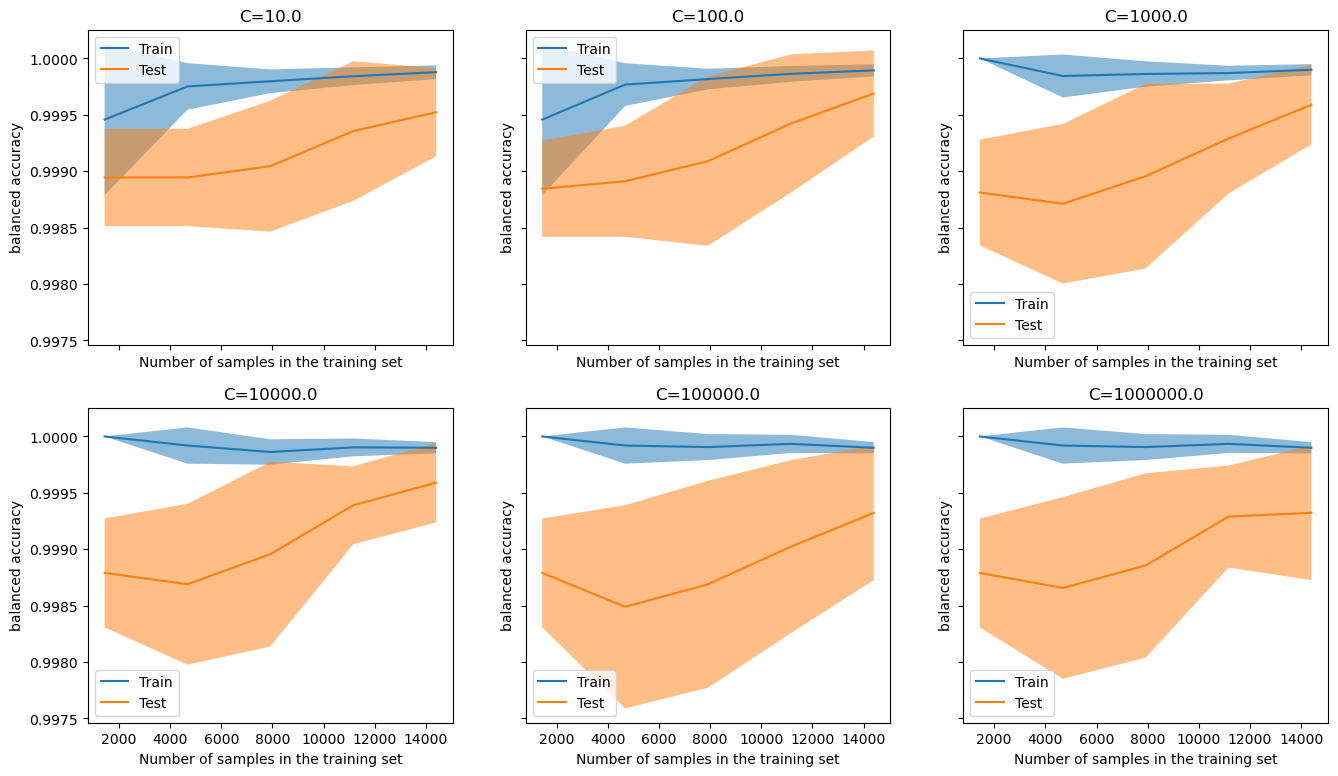

In [67]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots( nrows = 2, ncols = 3, figsize=(16,9), dpi=100, sharey=True, sharex=True )
for C, ax in zip( np.logspace(1,6,6), axs.reshape(-1) ):
    train_sizes = np.arange(0.1,1.1,0.1)
    pipeline = LogisticRegression(C=C, tol=1e-8, random_state=1, class_weight="balanced", max_iter=200)
    (train_sizes, 
    train_scores, 
    test_scores) = learning_curve(pipeline, X_final, y, 
                                  scoring=balanced_acc, 
                                  n_jobs=-1,
                                  shuffle=True,
                                  random_state=0)
    display = LearningCurveDisplay(train_sizes=train_sizes, train_scores=train_scores, test_scores=test_scores)
    display.plot(ax=ax)
    ax.set_title(f"C={C}")
    ax.set_ylabel("balanced accuracy")
fig.show()

In [69]:
final_clf = LogisticRegression(C=1e4, tol=1e-8, random_state=1, class_weight="balanced", max_iter=200)

In [72]:
final_clf.fit(X_final, y)

/Users/jvillanueva/anaconda3/envs/statML/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=10000.0, class_weight='balanced', max_iter=200,
                   random_state=1, tol=1e-08)

In [73]:
testset = load_dataset("test_data.json")
test_texts = [ sentencify(instance['text']) for instance in testset ]

In [74]:
test_domain_features = DC_vectorizer_mnb.transform( test_texts ).toarray()
test_domain_probs = DC_mnb.predict_proba( test_domain_features )[:,1]
del test_domain_features

In [76]:
test_domain1_features = D1_vectorizer_lr.transform( test_texts ).toarray()

lengths = np.zeros( (4000, 2) )
for i in range(4000):
    for k in range(2):
        lengths[i,k] = len(testset[i]['text'])**(k+1)
        
test_domain1_features = np.hstack( (test_domain1_features, lengths) )
test_domain1_probs = D1_lr.predict_proba( test_domain1_features )[:,1]

del test_domain1_features

In [78]:
test_domain2_features = D2_vectorizer_lr.transform( test_texts ).toarray()

test_domain2_features = np.hstack( (test_domain2_features, lengths) )
test_domain2_probs = D2_lr.predict_proba( test_domain2_features )[:,1]

del test_domain2_features

In [92]:
lengths = np.zeros( (18000, 2) )
for i in range(5000):
    for k in range(2):
        lengths[i,k] = len(dataset_1[i]['text'])**(k+1)
for i in range(13000):
    for k in range(2):
        lengths[5000+i,k] = len(dataset_2[i]['text'])**(k+1)
max_1, max_2 = lengths.max(axis=0)

In [93]:
lengths = np.zeros( (4000, 2) )
for i in range(4000):
    for k in range(2):
        lengths[i,k] = len(testset[i]['text'])**(k+1)
lengths[:,0] /= max_1
lengths[:,1] /= max_2

In [95]:
test_domain12_features = tfidf_vectorizer.transform( test_texts ).toarray()
test_domain12_features = np.hstack( (test_domain12_features, lengths) )
test_domain12_features = selector.transform(test_domain12_features)
test_domain12_features = torch.from_numpy(test_domain12_features).float().to(mps_device)
test_domain12_probs = model.predict(test_domain12_features).cpu().detach().numpy()
del test_domain12_features

In [98]:
test_features = np.zeros( (4000, 8) )
test_features[:,0] = test_domain1_probs
test_features[:,1] = test_domain1_probs * test_domain_probs
test_features[:,2] = test_domain2_probs
test_features[:,3] = test_domain2_probs * test_domain_probs
test_features[:,4:8] = test_domain12_probs

In [112]:
test_preds = final_clf.predict( test_features )
test_preds[ np.where(test_preds == 2) ] = 0
test_preds[ np.where(test_preds == 3) ] = 1

In [113]:
import pandas as pd
predictions = pd.DataFrame( test_preds, index=range(4000), columns=[ "class" ])

In [114]:
predictions.to_csv("sample.csv", sep=",", header=True, index_label="id")

In [115]:
!kaggle competitions submit -c comp90051-2024s1-project-1 -f sample.csv -m "Ensemble method LR[ MNB-LR-LR-NN ]"

100%|██████████████████████████████████████| 26.3k/26.3k [00:00<00:00, 30.4kB/s]
Successfully submitted to COMP90051 2024S1 Project 1